# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a dataset

Due to the unavailability of a dataset that met our project requirements, we created our own dataset by injecting different types of anomalies.

In [4]:
def generate_smart_bin_data(num_samples=10000):
    np.random.seed(42)
    
    # Generate normal feature values
    temperature = np.random.normal(25, 5, num_samples)
    pressure = np.random.normal(1, 0.1, num_samples)
    vibration = np.random.normal(0.5, 0.05, num_samples)
    co2 = np.random.normal(400, 50, num_samples)
    o2 = np.random.normal(21, 1, num_samples)
    rpm = np.random.normal(1500, 100, num_samples)
    load_weight = np.random.normal(50, 10, num_samples)

    fault_type = np.array(['normal'] * num_samples)

    # Inject sensor failures when temperature or pressure is abnormal
    sensor_failure_idx = np.where(
        (temperature > 35) | (temperature < 15) | (pressure < 0.8) | (pressure > 1.2)
    )[0]
    
    # Inject motor issues when vibration or rpm is abnormal
    motor_issue_idx = np.where(
        (vibration > 0.65) | (vibration < 0.35) | (rpm < 1300) | (rpm > 1700)
    )[0]

    # Mark the faults
    fault_type[sensor_failure_idx] = 'sensor_failure'
    fault_type[motor_issue_idx] = 'motor_issue'

    # Avoid double-marking
    overlap_idx = np.intersect1d(sensor_failure_idx, motor_issue_idx)
    fault_type[overlap_idx] = 'sensor_failure'

    data = {
        'temperature': temperature,
        'pressure': pressure,
        'vibration': vibration,
        'co2': co2,
        'o2': o2,
        'rpm': rpm,
        'load_weight': load_weight,
        'fault_type': fault_type
    }
    return pd.DataFrame(data)

# Preprocess data

In [6]:
df = generate_smart_bin_data()
features = ['temperature', 'pressure', 'vibration', 'co2', 'o2', 'rpm', 'load_weight']
df['label'] = (df['fault_type'] != 'normal').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df['label'], test_size=0.3, random_state=42, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
df.head()

,temperature,pressure,vibration,co2,o2,rpm,load_weight,fault_type,label
0,27.483571,0.932151,0.517414,300.971402,20.528142,1509.820615,50.788378,normal,0
1,24.308678,0.969450,0.514166,347.250718,22.012702,1493.589177,55.628975,normal,0
2,28.238443,0.940262,0.453174,370.648580,20.801813,1595.179076,53.411020,normal,0
3,32.615149,1.011042,0.528979,407.483446,21.090569,1653.283114,37.220858,normal,0
4,23.829233,1.119718,0.425496,451.208116,21.717391,1568.684694,48.137797,normal,0


# Encoder model

In [9]:
def build_autoencoder(input_dim):
    inputs = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(inputs)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001
)

autoencoder = build_autoencoder(X_train_scaled.shape[1])
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Autoencoder predictions
test_recon = autoencoder.predict(X_test_scaled)
test_mse = np.mean(np.square(X_test_scaled - test_recon), axis=1)
threshold = np.percentile(test_mse, 95)
ae_predictions = (test_mse > threshold).astype(int)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


## Model evaluation

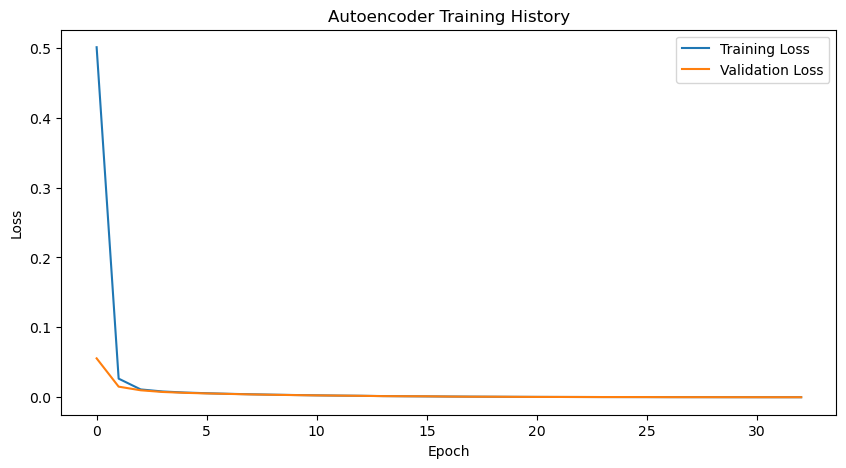

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Machine learning models (One-class SVM - IForest - LOF)

In [13]:
models = {
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42),
    "One-Class SVM": OneClassSVM(nu=0.05, kernel='rbf'),
    "Local Outlier Factor": LocalOutlierFactor(novelty=True, contamination=0.05)
}

results = {}
model_preds = {}

for name, model in models.items():
    try:
        if name == "One-Class SVM":
            model.fit(X_train_scaled[y_train == 0])  # Train only on normal data
        else:
            model.fit(X_train_scaled)

        pred = model.predict(X_test_scaled)
        pred = np.where(pred == -1, 1, 0)
        
        results[name] = classification_report(y_test, pred)
        model_preds[name] = pred
        
    except Exception as e:
        print(f"Error with {name}: {str(e)}")


## Model performance comparison

In [15]:
results["Autoencoder"] = classification_report(y_test, ae_predictions)
model_preds["Autoencoder"] = ae_predictions

print("\n=== Model Performance Comparison ===")
for name, report in results.items():
    print(f"\n** {name} **\n{report}")


=== Model Performance Comparison ===

** Isolation Forest **
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2591
           1       0.61      0.19      0.29       409

    accuracy                           0.87      3000
   macro avg       0.75      0.59      0.61      3000
weighted avg       0.85      0.87      0.84      3000


** One-Class SVM **
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2591
           1       0.65      0.54      0.59       409

    accuracy                           0.90      3000
   macro avg       0.79      0.75      0.77      3000
weighted avg       0.89      0.90      0.89      3000


** Local Outlier Factor **
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2591
           1       0.58      0.17      0.27       409

    accuracy                           0.87      3000
   macro avg     

## Model evaluation

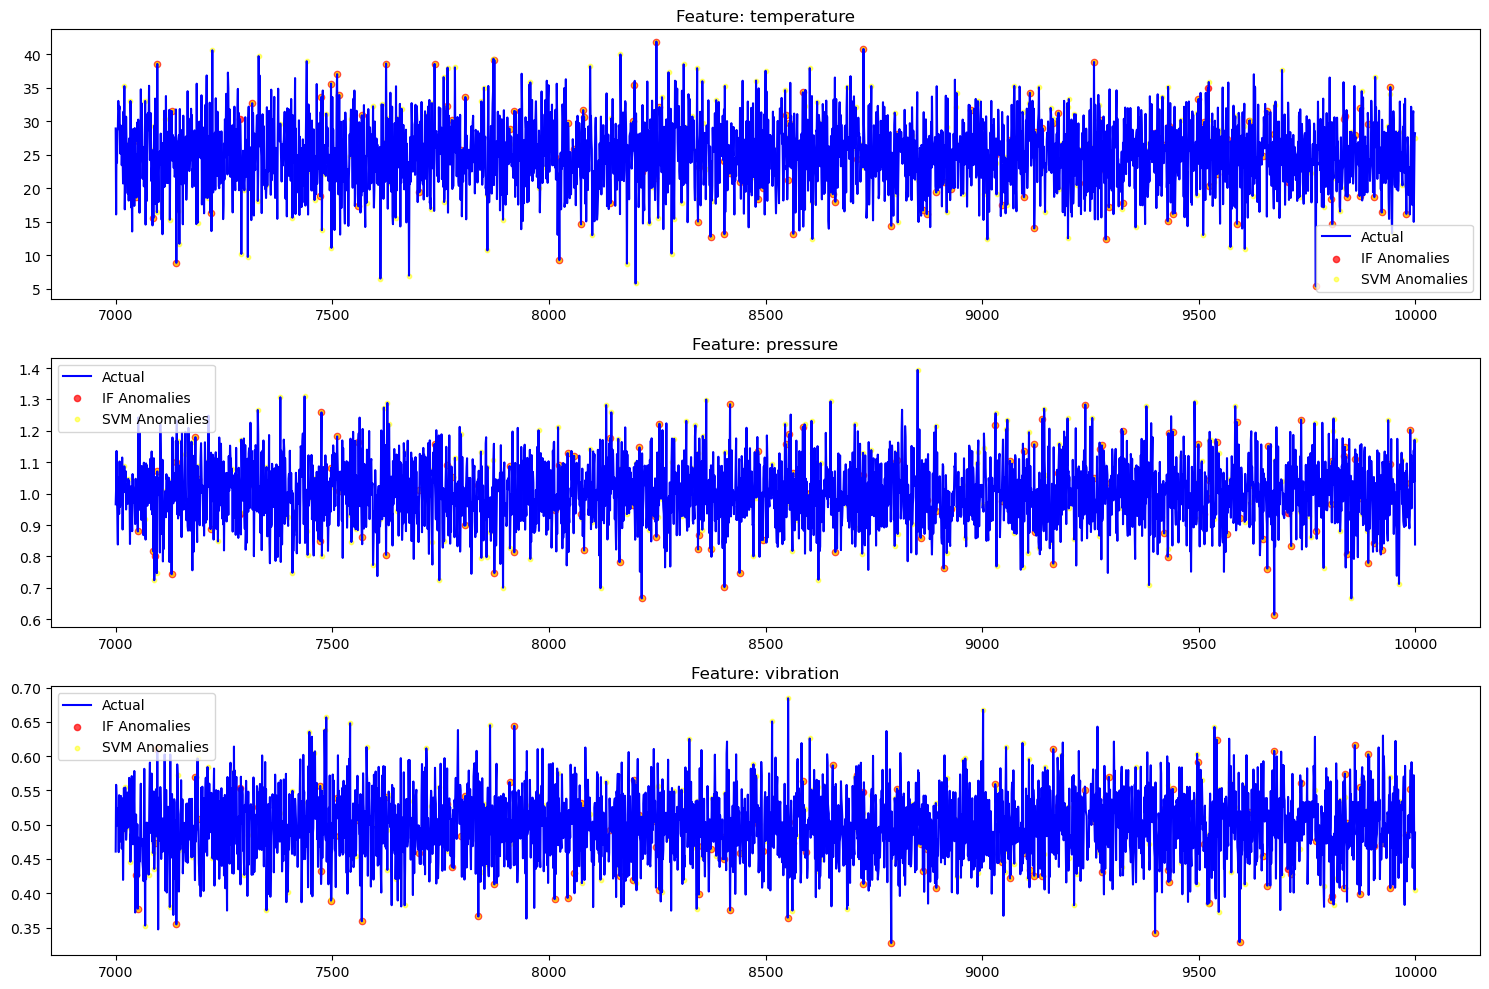

In [17]:
iso_pred = model_preds["Isolation Forest"]
svm_pred = model_preds["One-Class SVM"]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features[:3], 1):  # Plot first 3 features
    plt.subplot(3, 1, i)
    plt.plot(X_test.index, X_test[feature], label='Actual', color='blue')
    plt.scatter(X_test.index[iso_pred == 1], X_test[feature][iso_pred == 1], 
                c='red', s=20, label='IF Anomalies', alpha=0.7)
    plt.scatter(X_test.index[svm_pred == 1], X_test[feature][svm_pred == 1],
                c='yellow', s=10, label='SVM Anomalies', alpha=0.5)
    plt.title(f"Feature: {feature}")
    plt.legend()

plt.tight_layout()
plt.show()

# Fault Type classification

In [19]:
# Prepare full data for classification
X_all = df[features]
y_all_fault_type = df['fault_type']

# Encode fault type
label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all_fault_type)
class_names = label_encoder.classes_

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_all, y_all_encoded, test_size=0.3, random_state=42, shuffle=True
)

scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

y_train_cat = to_categorical(y_train_cls)
y_test_cat = to_categorical(y_test_cls)

# Build classifier
def build_classifier(input_dim, num_classes):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

classifier = build_classifier(X_train_cls_scaled.shape[1], len(class_names))

early_stopping_cls = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001
)

history_cls = classifier.fit(
    X_train_cls_scaled, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping_cls],
    verbose=0
)

# Predictions
y_pred_prob_cls = classifier.predict(X_test_cls_scaled)
y_pred_cls = np.argmax(y_pred_prob_cls, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


# Model evaluation


=== Classification Report (Fault Type) ===
              precision    recall  f1-score   support

      motor_       0.93      0.85      0.89       155
      normal       0.98      0.99      0.99      2571
      sensor       0.92      0.91      0.91       274

    accuracy                           0.97      3000
   macro avg       0.94      0.92      0.93      3000
weighted avg       0.97      0.97      0.97      3000



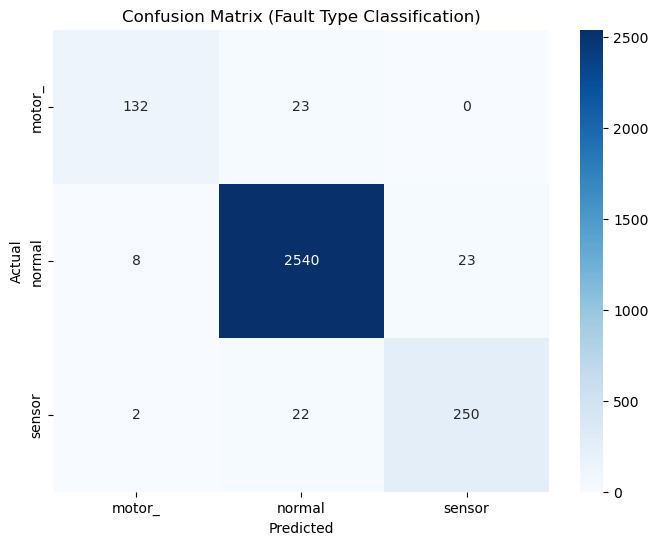

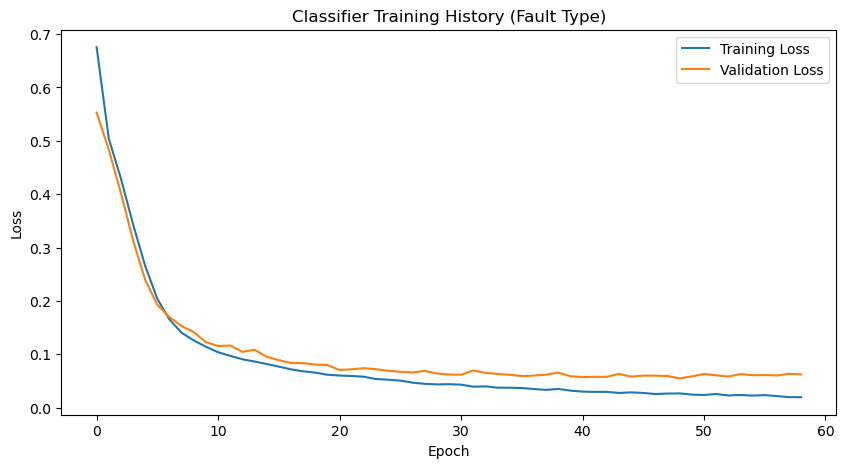

In [21]:
# Classification Report
print("\n=== Classification Report (Fault Type) ===")
print(classification_report(y_test_cls, y_pred_cls, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Fault Type Classification)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(history_cls.history['loss'], label='Training Loss')
plt.plot(history_cls.history['val_loss'], label='Validation Loss')
plt.title('Classifier Training History (Fault Type)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Importing Data from Local Storage

In [42]:
df = pd.read_csv('C:/Users/21699/Desktop/sensor_data.csv')  
df.head()

,id,gas_level,temperature,humidity,leak_detected,timestamp
0,1,3628,24.0,40.0,1,2025-04-20 04:42:41
1,2,3628,24.0,40.0,1,2025-04-20 04:42:41
2,3,3628,24.0,40.0,1,2025-04-20 04:42:43
3,4,3628,24.0,40.0,1,2025-04-20 04:42:44
4,5,3628,24.0,40.0,1,2025-04-20 04:42:45
